In [74]:
import os
import pandas as pd
import numpy as np
import qiime2 as q2
from biom import Table
from skbio import TreeNode
from gneiss.util import match
from sklearn import preprocessing
from skbio.stats.composition import clr, closure
from sklearn.cluster.bicluster import SpectralCoclustering
from qiime2.plugins.phylogeny.methods import midpoint_root
from qiime2.plugins.diversity.actions import core_metrics_phylogenetic

from gneiss.cluster._pba import correlation_linkage, gradient_linkage
from gneiss.sort import gradient_sort, mean_niche_estimator

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
from matplotlib import ticker

plt.style.use('ggplot')
%matplotlib inline

In [40]:
# tree 
tree_ = q2.Artifact.import_data('Phylogeny[Unrooted]', 'data/resources/97_otus.tree')
tree_rooted = midpoint_root(tree_)
# fix tree rooting issues
tree = tree_rooted.rooted_tree.view(TreeNode)
for n in tree.postorder(include_self=True):
    if n.length is None:
        n.length = 0
rooted_tree_fixed = q2.Artifact.import_data('Phylogeny[Rooted]',
                                            tree)
# save
rooted_tree_fixed.save('data/resources/97_otus.qza')

'data/resources/97_otus.qza'

In [41]:
# keyboard dataset
kb_table = q2.Artifact.import_data('FeatureTable[Frequency]',
                                   'data/keyboard/46809_otu_table.biom').view(Table)
kb_mf = q2.Metadata.load('data/keyboard/232_20170409-171325.txt').to_dataframe()
kb_mf = kb_mf[kb_mf.host_subject_id.isin(['M2','M3', 'M9'])]
kb_table = kb_table.filter(kb_mf.index)
kb_table = kb_table.filter(kb_table.ids('observation')[kb_table.sum('observation') > 0],
                           'observation')
kb_table = q2.Artifact.import_data('FeatureTable[Frequency]',
                                   kb_table)
kb_mf = q2.Metadata(kb_mf)

# 88 soils
soil_table = q2.Artifact.import_data('FeatureTable[Frequency]',
                                     'data/soils/44763_otu_table.biom').view(Table)
soil_mf = q2.Metadata.load('data/soils/103_20171215-103619.txt').to_dataframe()
# filter sample with 2 reads
soil_table = soil_table.filter(soil_table.ids('sample')[soil_table.sum('sample') > 500],
                               'sample')
soil_table = soil_table.filter(soil_table.ids('observation')[soil_table.sum('observation') > 0],
                               'observation')
soil_mf = q2.Metadata(soil_mf.reindex(soil_table.ids()))
soil_table = q2.Artifact.import_data('FeatureTable[Frequency]',
                                     soil_table)

### keyboard data heatmap

In [95]:
meta = kb_mf.to_dataframe()
bttable = kb_table.view(Table)
table = pd.DataFrame(bttable.matrix_data.toarray(),
             bttable.ids('observation'), bttable.ids())
table = table.reindex(meta.index, axis=1)
table = table.loc[table.sum(1) > 20,
                  table.sum(0) > 500]

table, meta = match(table.T, meta)

le = preprocessing.LabelEncoder()
le.fit(meta['host_subject_id'])
meta['encoded'] = le.transform(meta['host_subject_id']) 

table_grad = table.copy()
table_grad.sort_index()
c = pd.Series(meta['encoded'])
table, c = match(table_grad, c)
t = gradient_linkage(table_grad + 1, c, method='average')
mean_g = mean_niche_estimator(table_grad, c)
mean_g = pd.Series(mean_g, index=table_grad.columns)
mean_g = mean_g.sort_values()


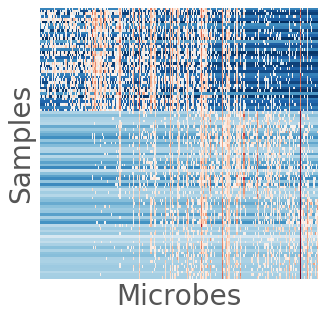

In [97]:
# plot the data
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

fig, ax = plt.subplots(1,1, figsize=(5,5))
    
table_grad = table_grad.reindex(index=meta.sort_values('encoded').index,
                                columns=mean_g.index)
ax.imshow(clr(table_grad+1),
          aspect='auto',
          norm=MidpointNormalize(midpoint=0.),
          cmap='RdBu_r')
#ax.title('Keyboard Dataset Sorted by Subject',fontsize=20)
ax.set_ylabel('Samples',fontsize=28)
ax.set_xlabel('Microbes',fontsize=28)
ax.set_xticks([])
ax.set_yticks([])
plt.show()


In [103]:
meta = soil_mf.to_dataframe()
bttable = soil_table.view(Table)
table = pd.DataFrame(bttable.matrix_data.toarray(),
             bttable.ids('observation'), bttable.ids())
table = table.reindex(meta.index, axis=1)
table = table.loc[table.sum(1) > 3,
                  table.sum(0) > 500]

table, meta = match(table.T, meta)

# order grad
table_grad = table.copy()
table_grad.sort_index()
c = pd.Series(meta['ph'])
table, c = match(table_grad, c)
#order gradient 
t = gradient_linkage(table_grad+1, c, method='average')
mean_g = mean_niche_estimator(table_grad, c)
mean_g = pd.Series(mean_g, index=table_grad.columns)
mean_g = mean_g.sort_values()
# plot the gradient
table_grad = table_grad.reindex(index=meta.sort_values('ph').index,
                                columns=mean_g.index)


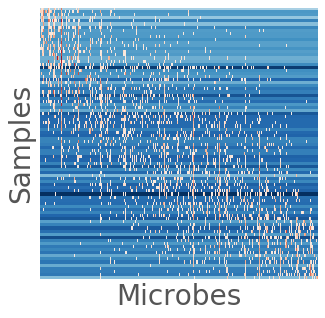

In [104]:
# plot the data
class MidpointNormalize(colors.Normalize):
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))
    

fig, ax = plt.subplots(1,1, figsize=(5,5))
    
table_grad = table_grad.reindex(index=meta.sort_values('ph').index,
                                columns=mean_g.index)
ax.imshow(clr(table_grad+1),
          aspect='auto',
          norm=MidpointNormalize(midpoint=0.),
          cmap='RdBu_r')
#ax.title('Keyboard Dataset Sorted by Subject',fontsize=20)
ax.set_ylabel('Samples',fontsize=28)
ax.set_xlabel('Microbes',fontsize=28)
ax.set_xticks([])
ax.set_yticks([])
plt.show()


In [35]:
data = clr(data + 1)
model = SpectralCoclustering(n_clusters=2,
                             random_state=0)
model.fit(data)
fit_data = data[np.argsort(model.row_labels_)]
fit_data = fit_data[:, np.argsort(model.column_labels_)]


array([[ 0.66951716,  0.66951716,  0.66951716, ..., -0.02363002,
        -0.02363002, -0.02363002],
       [-0.12797025, -0.12797025,  0.97064203, ..., -0.12797025,
        -0.12797025, -0.12797025],
       [-0.00787667, -0.00787667, -0.00787667, ..., -0.00787667,
        -0.00787667, -0.00787667],
       ...,
       [-0.00787667, -0.00787667, -0.00787667, ..., -0.00787667,
        -0.00787667, -0.00787667],
       [-0.05974427, -0.05974427, -0.05974427, ..., -0.05974427,
        -0.05974427, -0.05974427],
       [-0.05974427, -0.05974427, -0.05974427, ..., -0.05974427,
        -0.05974427, -0.05974427]])

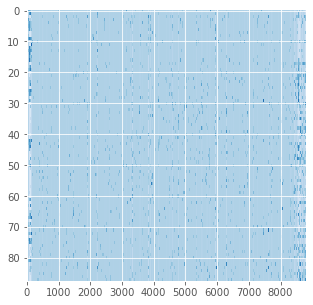

In [34]:
fig, ax = plt.subplots(1,1, figsize=(5,5))

ax.imshow(fit_data.T, cmap=plt.cm.Blues, interpolation='nearest', aspect='auto')
plt.show()
